# Imports and setup

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
snd_cert_path = "./data/syscalls/snd-cert"
snd_unm_path = "./data/syscalls/snd-unm"

## Load the data

In [4]:
snd_cert_1_data = pd.DataFrame()
snd_cert_1_data["data"] = pd.read_csv(snd_cert_path + "/snd-cert.1.test")
snd_cert_1_data["label"] = pd.read_csv(snd_cert_path + "/snd-cert.1.labels")

snd_cert_2_data = pd.DataFrame()
snd_cert_2_data["data"] = pd.read_csv(snd_cert_path + "/snd-cert.2.test")
snd_cert_2_data["label"] = pd.read_csv(snd_cert_path + "/snd-cert.2.labels")

snd_cert_3_data = pd.DataFrame()
snd_cert_3_data["data"] = pd.read_csv(snd_cert_path + "/snd-cert.3.test")
snd_cert_3_data["label"] = pd.read_csv(snd_cert_path + "/snd-cert.3.labels")

snd_cert_train_data = pd.DataFrame()
snd_cert_train_data["data"] = pd.read_csv(snd_cert_path + "/snd-cert.train")
snd_cert_train_data["label"] = 0

In [5]:
snd_unm_1_data = pd.DataFrame()
snd_unm_1_data["data"] = pd.read_csv(snd_unm_path + "/snd-unm.1.test")
snd_unm_1_data["label"] = pd.read_csv(snd_unm_path + "/snd-unm.1.labels")

snd_unm_2_data = pd.DataFrame()
snd_unm_2_data["data"] = pd.read_csv(snd_unm_path + "/snd-unm.2.test")
snd_unm_2_data["label"] = pd.read_csv(snd_unm_path + "/snd-unm.2.labels")


snd_unm_3_data = pd.DataFrame()
snd_unm_3_data["data"] = pd.read_csv(snd_unm_path + "/snd-unm.3.test")
snd_unm_3_data["label"] = pd.read_csv(snd_unm_path + "/snd-unm.3.labels")

snd_unm_train_data = pd.DataFrame()
snd_unm_train_data["data"] = pd.read_csv(snd_unm_path + "/snd-unm.train")
snd_unm_train_data["label"] = 0

# Preprocessing

In [6]:
def preprocess_data_frame(df: pd.DataFrame) -> pd.DataFrame:
    """
    Perform any preprocessing steps in a single data frame

    We assign a new id column and a new column with the length of the data
    """
    # assign a unique id to each data element so when we split them in substrings, we can then get back to the original
    # and conclude about the final class
    df["id"] = range(len(df))

    df["length"] = df["data"].str.len()

    return df


def extract_substrings(df: pd.DataFrame, substr_len: int = 7) -> pd.DataFrame:
    """
    Create a new dataframe with all the substrings from each row
    We will try to get non overlapping substrings, but if the text is not divisible by the desired length, then for the
    last substring we will get the last substr_len elements of the string

    This method returns a dataframe with the substrings and the label of the original string
    """
    # note for improvement, check the apply method of data frame paired with explode
    substr_df = {"data": [], "label": [], "id": []}
    for index, row in df.iterrows():
        text = row["data"]
        label = row["label"]
        id = row["id"]
        substrings = []
        length = row["length"]
        start = 0
        while start < length:
            end = start + substr_len
            if end < length:
                substrings.append(text[start:end])
            else:
                substrings.append(text[-substr_len:])
            start = end

        substr_df["data"].extend(substrings)
        substr_df["label"].extend(label for i in range(len(substrings)))
        substr_df["id"].extend(id for i in range(len(substrings)))

    return pd.DataFrame(substr_df)


def preprocess(df: pd.DataFrame, name: str, data_path: str, is_train: bool = False) -> None:
    """
    Apply all the preprocessing steps in a dataframe and save all the resulting dataframes
    """
    df = preprocess_data_frame(df)
    df.to_csv(data_path + "/" + name + ".csv")

    # extract substrings and save the new dataframe
    df_substr = extract_substrings(df)
    df_substr.to_csv(data_path + "/" + name + "_substr.csv")

    # save the data in a file to be used in the negative selection algorithm
    df_substr["data"].to_csv(
        data_path + "/" + name + "_substr" + (".train" if is_train else ".test"),
        header=False,
        index=False,
    )

In [7]:
def analyse_df(df: pd.DataFrame, name: str) -> None:
    print("Counts for df " + name)
    display(df.groupby("length").count())

    print("Counts for labels " + name)
    display(df.groupby("label").count())

In [8]:
# analyse_df(snd_cert_2_data, "snd_cert_2_data")
# analyse_df(snd_cert_2_data, "snd_cert_2_data")
# analyse_df(snd_cert_3_data, "snd_cert_3_data")

# analyse_df(snd_unm_1_data, "snd_unm_1_data")
# analyse_df(snd_unm_2_data, "snd_unm_2_data")
# analyse_df(snd_unm_3_data, "snd_unm_3_data")

Preprocess and save all the data

In [9]:
preprocess(snd_cert_2_data, "snd_cert_2", snd_cert_path)
preprocess(snd_cert_2_data, "snd_cert_2", snd_cert_path)
preprocess(snd_cert_3_data, "snd_cert_3", snd_cert_path)
preprocess(snd_cert_train_data, "snd_cert_train", snd_cert_path, True)

preprocess(snd_unm_1_data, "snd_unm_1", snd_unm_path)
preprocess(snd_unm_2_data, "snd_unm_2", snd_unm_path)
preprocess(snd_unm_3_data, "snd_unm_3", snd_unm_path)
preprocess(snd_unm_train_data, "snd_unm_train", snd_unm_path, True)

KeyboardInterrupt: 

# Run negative selection

In [ ]:
import subprocess

for r in range(1, 8):
    for i in range(1, 3):
        cmd = (
            "java -jar negsel2.jar -alphabet file://data/syscalls/snd-cert/snd-cert.alpha"
            " -self ./data/syscalls/snd-cert/snd_cert_train_substr.train -n 7 -l -c -r "
            + str(r)
            + " < ./data/syscalls/snd-cert/snd_cert_"
            + str(i)
            + "_substr.test > "
            "./data/syscalls/snd-cert/snd_cert_" + str(i) + "_substr_res_" + str(r) + ".txt"
        )
        subprocess.run(cmd, capture_output=True, shell=True)

In [92]:
for r in range(1, 8):
    cmd = (
        "java -jar negsel2.jar -alphabet file://data/syscalls/snd-unm/snd-unm.alpha"
        " -self ./data/syscalls/snd-unm/snd_unm_train_substr.train -n 7 -l -c -r "
        + str(r)
        + " < ./data/syscalls/snd-unm/snd_unm_1_substr.test > "
        "./data/syscalls/snd-unm/snd_unm_1_substr_res_" + str(r) + ".txt"
    )
    subprocess.run(cmd, capture_output=True, shell=True)

In [98]:
for r in range(5, 8):
    cmd = (
        "java -jar negsel2.jar -alphabet file://data/syscalls/snd-unm/snd-unm.alpha"
        " -self ./data/syscalls/snd-unm/snd_unm_train_substr.train -n 7 -l -c -r "
        + str(r)
        + " < ./data/syscalls/snd-unm/snd_unm_2_substr.test > "
        "./data/syscalls/snd-unm/snd_unm_2_substr_res_" + str(r) + ".txt"
    )
    subprocess.run(cmd, capture_output=True, shell=True)

In [ ]:
cmd = (
    "java -jar negsel2.jar -alphabet file://data/syscalls/snd-cert/snd-cert.alpha"
    " -self ./data/syscalls/snd-cert/snd_cert_train_substr.train -n 7 -l -c -r 7"
    " < ./data/syscalls/snd-cert/snd_cert_3_substr.test > "
    "./data/syscalls/snd-cert/snd_cert_3_substr_res_7.txt"
)
subprocess.run(cmd, capture_output=True, shell=True)

cmd = (
    "java -jar negsel2.jar -alphabet file://data/syscalls/snd-unm/snd-unm.alpha"
    " -self ./data/syscalls/snd-unm/snd_unm_train_substr.train -n 7 -l -c -r 6"
    " < ./data/syscalls/snd-unm/snd_unm_3_substr.test > "
    "./data/syscalls/snd-unm/snd_unm_3_substr_res_6.txt"
)
subprocess.run(cmd, capture_output=True, shell=True)

CompletedProcess(args='java -jar negsel2.jar -alphabet file://data/syscalls/snd-unm/snd-unm.alpha -self ./data/syscalls/snd-unm/snd_unm_train_substr.train -n 7 -l -c -r 6 < ./data/syscalls/snd-unm/snd_unm_3_substr.test > ./data/syscalls/snd-unm/snd_unm_3_substr_res_6.txt', returncode=0, stdout=b'', stderr=b'')

# Classification

In [110]:
def load_results(res_file: str, substr_file: str) -> metrics.RocCurveDisplay:
    df = pd.DataFrame()
    df["score"] = pd.read_csv(res_file)
    df["data"] = pd.read_csv(substr_file, usecols=["data"])
    df["label"] = pd.read_csv(substr_file, usecols=["label"])
    df["id"] = pd.read_csv(substr_file, usecols=["id"])

    return df


def average_scores(df: pd.DataFrame):
    avg_df = df.groupby("id", as_index=False)["score"].mean().reset_index()
    df_labels = df.groupby("id")["label"].first().reset_index()
    avg_df = pd.merge(avg_df, df_labels, on="id")
    avg_df.drop(columns=["index", "id"], inplace=True)

    return avg_df


def calculate_auc(res_file: str, substr_file: str, name: str):
    df = load_results(res_file, substr_file)
    avg_df = average_scores(df)
    auc = metrics.roc_auc_score(avg_df["label"], avg_df["score"])
    print("AUC for " + name)
    print(auc)

    fpr, tpr, thresholds = metrics.roc_curve(avg_df["label"], avg_df["score"])
    roc = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
    return roc

In [56]:
# cert_1
for r in range(1, 8):
    res_file = snd_cert_path + "/snd_cert_1_substr_res_" + str(r) + ".txt"
    substr_file = snd_cert_path + "/snd_cert_1_substr.csv"
    name = "snd_cert_1_results_" + str(r)
    calculate_auc(res_file, substr_file, name)

AUC for snd_cert_1_results_1
0.7375510204081632
AUC for snd_cert_1_results_2
0.9408163265306122
AUC for snd_cert_1_results_3
0.9444897959183673
AUC for snd_cert_1_results_4
0.9453061224489796
AUC for snd_cert_1_results_5
0.9448979591836735
AUC for snd_cert_1_results_6
0.9526530612244898
AUC for snd_cert_1_results_7
0.9542857142857143


In [58]:
# cert_2
for r in range(1, 8):
    res_file = snd_cert_path + "/snd_cert_2_substr_res_" + str(r) + ".txt"
    substr_file = snd_cert_path + "/snd_cert_2_substr.csv"
    name = "snd_cert_2_results_" + str(r)
    calculate_auc(res_file, substr_file, name)

AUC for snd_cert_2_results_1
0.7723446893787576
AUC for snd_cert_2_results_2
0.948496993987976


AUC for snd_cert_2_results_3
0.9657715430861723
AUC for snd_cert_2_results_4
0.9661322645290581
AUC for snd_cert_2_results_5
0.9662124248496994
AUC for snd_cert_2_results_6
0.9670340681362726
AUC for snd_cert_2_results_7
0.9671342685370741


In [ ]:
# unm_1
for r in range(1, 8):
    res_file = snd_unm_path + "/snd_unm_1_substr_res_" + str(r) + ".txt"
    substr_file = snd_unm_path + "/snd_unm_1_substr.csv"
    name = "snd_unm_1_results_" + str(r)
    calculate_auc(res_file, substr_file, name)

AUC for snd_unm_1_results_1
0.6191836734693879
AUC for snd_unm_1_results_2
0.8577551020408163
AUC for snd_unm_1_results_3
0.91
AUC for snd_unm_1_results_4
0.9104081632653062
AUC for snd_unm_1_results_5
0.9344897959183673
AUC for snd_unm_1_results_6
0.9355102040816325
AUC for snd_unm_1_results_7
0.9367346938775509


In [100]:
# unm_2
for r in range(5, 8):
    res_file = snd_unm_path + "/snd_unm_2_substr_res_" + str(r) + ".txt"
    substr_file = snd_unm_path + "/snd_unm_2_substr.csv"
    name = "snd_unm_2_results_" + str(r)
    calculate_auc(res_file, substr_file, name)

AUC for snd_unm_2_results_5
0.9624048096192385
AUC for snd_unm_2_results_6
0.9624448897795591
AUC for snd_unm_2_results_7
0.9624248496993988


## Visualisations

AUC for snd_cert_1_results_7
0.9542857142857143
AUC for snd_cert_1_results_7
0.9542857142857143
AUC for snd_cert_2_results_7
0.9671342685370741
AUC for snd_cert_2_results_7
0.9671342685370741


EmptyDataError: No columns to parse from file

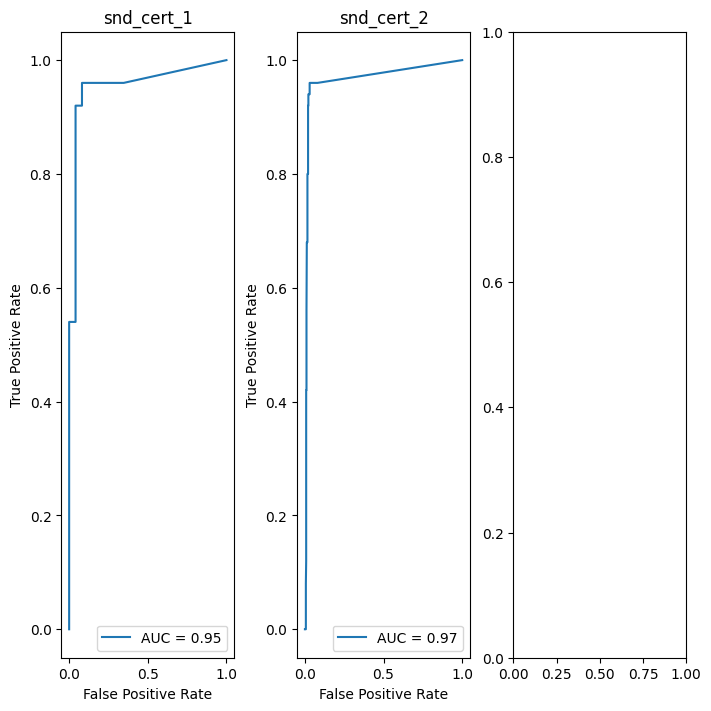

In [113]:
fig, axes = plt.subplots(1, 3, figsize=(7, 7), constrained_layout=True)

for i, ax in enumerate(axes.flatten()):
    x = i + 1
    res_file = snd_cert_path + "/snd_cert_" + str(x) + "_substr_res_7.txt"
    substr_file = snd_cert_path + "/snd_cert_" + str(x) + "_substr.csv"
    name = "snd_cert_" + str(x) + "_results_7"
    calculate_auc(res_file, substr_file, name)
    roc = calculate_auc(res_file, substr_file, name)
    roc.plot(ax=ax)
    ax.set_title(f"snd_cert_{x}")

AUC for snd_unm_1_results_7
0.9367346938775509
AUC for snd_unm_2_results_6
0.9624448897795591
AUC for snd_unm_3_results_6
0.9938738738738739


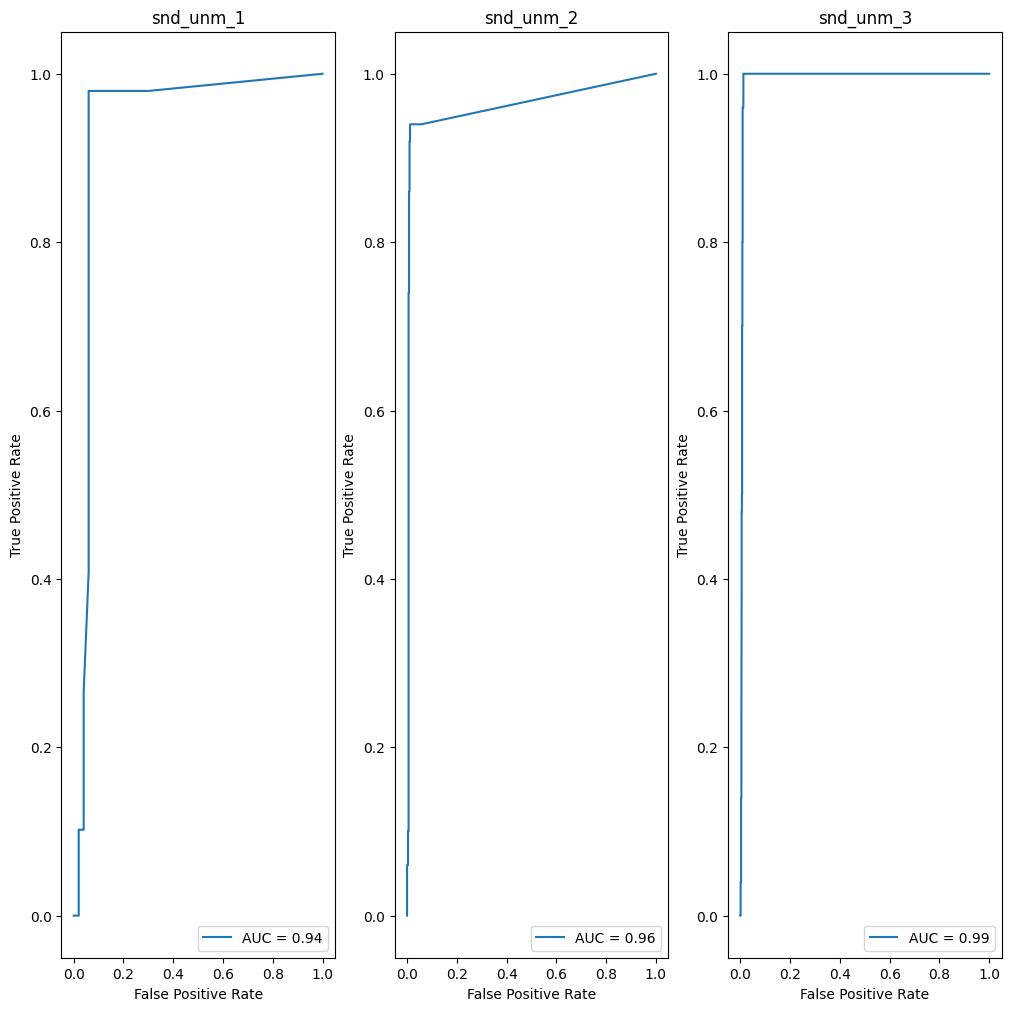

In [114]:
fig, axes = plt.subplots(1, 3, figsize=(10, 10), constrained_layout=True)

for i, ax in enumerate(axes.flatten()):
    x = i + 1
    r = "7" if x == 1 else "6"
    res_file = snd_unm_path + "/snd_unm_" + str(x) + "_substr_res_" + r + ".txt"
    substr_file = snd_unm_path + "/snd_unm_" + str(x) + "_substr.csv"
    name = "snd_unm_" + str(x) + "_results_" + r
    roc = calculate_auc(res_file, substr_file, name)
    roc.plot(ax=ax)
    ax.set_title(f"snd_unm_{x}")